In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
# import lib
import numpy as np
import pandas as pd
import matplotlib  
import matplotlib.pyplot as plt  
import seaborn as sns
import sklearn
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import norm, skew 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import KFold ,RepeatedKFold
from sklearn.metrics import mean_squared_error
plt.rcParams.update({'font.size': 18})
plt.style.use('ggplot')
import xgboost as xgb
import math
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

# Read datasets

In [4]:
# read train dataset
df_train = pd.read_csv('/content/drive/MyDrive/WiDS Datathon 2022/train.csv')

# read test dataset
df_test = pd.read_csv('/content/drive/MyDrive/WiDS Datathon 2022/test.csv')

# combine the two datasets for easier processing 
df = pd.concat([df_train, df_test], axis = 0 )

In [5]:
df_train.shape, df_test.shape, df.shape

((75757, 64), (9705, 63), (85462, 64))

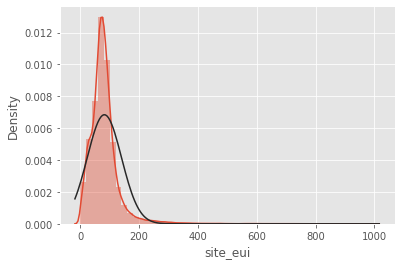

In [6]:
# inspect target variable distribution 
sns.distplot(df_train['site_eui'] , fit=norm);

- Our target variable, site_eui is skewed to the right with outliers having greater values than the core distribution of the variable

# Feature Engineering

In [7]:
df.describe()

Year_Factor    floor_area    year_built  energy_star_rating  \
count  85462.000000  8.546200e+04  83533.000000        56499.000000   
mean       4.666671  1.656694e+05   1953.562616           61.531850   
std        1.617635  2.486965e+05     37.667384           28.595425   
min        1.000000  9.430000e+02      0.000000            0.000000   
25%        3.000000  6.115500e+04   1927.000000           41.000000   
50%        5.000000  9.041100e+04   1954.000000           68.000000   
75%        6.000000  1.671960e+05   1981.000000           85.000000   
max        7.000000  6.385382e+06   2016.000000          100.000000   

          ELEVATION  january_min_temp  january_avg_temp  january_max_temp  \
count  85462.000000      85462.000000      85462.000000      85462.000000   
mean      58.325913         11.669502         34.579333         59.163230   
std      118.276994          9.801683          7.033171          5.425332   
min       -6.400000        -19.000000         10.806452         42.000000   
25%       11.900000          6.000000         29.827586         56.000000   
50%       25.600000         11.000000         34.451613         59.000000   
75%       42.700000         13.000000         37.322581         62.000000   
max     1924.500000         49.000000         64.758065         91.000000   

       february_min_temp  february_avg_temp  ...  days_above_80F  \
count       85462.000000       85462.000000  ...    85462.000000   
mean           12.854403          36.220463  ...       80.905385   
std            12.692836           8.770221  ...       26.471258   
min           -13.000000          13.250000  ...        0.000000   
25%             2.000000          31.625000  ...       72.000000   
50%             9.000000          36.053571  ...       77.000000   
75%            20.000000          40.879310  ...       96.000000   
max            48.000000          65.107143  ...      260.000000   

       days_above_90F  days_above_100F  days_above_110F  \
count    85462.000000     85462.000000     85462.000000   
mean        13.818247         0.271828         0.002165   
std         11.226827         2.130802         0.133828   
min          0.000000         0.000000         0.000000   
25%          5.000000         0.000000         0.000000   
50%         12.000000         0.000000         0.000000   
75%         17.000000         0.000000         0.000000   
max        185.000000       119.000000        16.000000   

       direction_max_wind_speed  direction_peak_wind_speed  max_wind_speed  \
count              35805.000000               35076.000000    35805.000000   
mean                  74.606452                  70.750627        4.630568   
std                  136.597569                 135.612018        6.816503   
min                    1.000000                   1.000000        1.000000   
25%                    1.000000                   1.000000        1.000000   
50%                    1.000000                   1.000000        1.000000   
75%                    1.000000                   1.000000        1.000000   
max                  360.000000                 360.000000       23.300000   

       days_with_fog      site_eui           id  
count   30549.000000  75757.000000  85462.00000  
mean      109.943010     82.584693  42730.50000  
std        51.186182     58.255403  24670.89869  
min        12.000000      1.001169      0.00000  
25%        88.000000     54.528601  21365.25000  
50%       106.000000     75.293716  42730.50000  
75%       131.000000     97.277534  64095.75000  
max       311.000000    997.866120  85461.00000  

[8 rows x 61 columns]

- The basic stats above show there are prevalent missing values across a few columns. Let's visualise the missing values. 

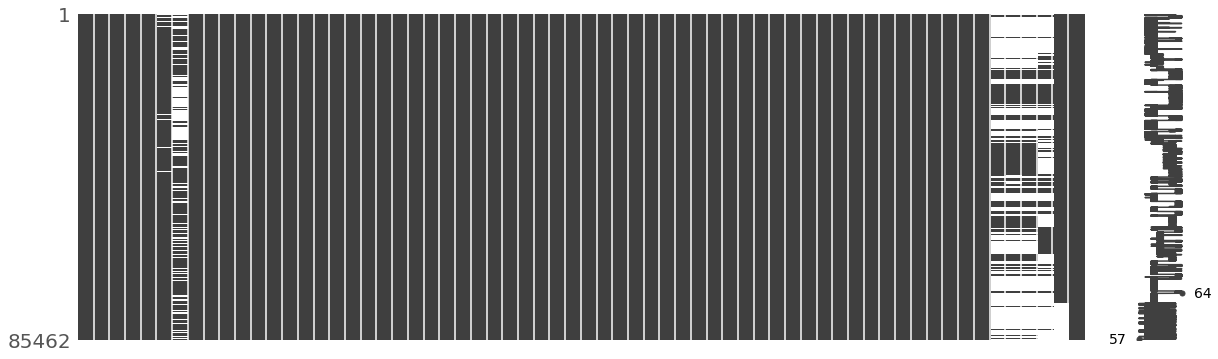

In [8]:
import missingno as mno

mno.matrix(df, figsize = (20, 6))

### Measure how many values are missing

In [9]:
missing_columns = [col for col in df.columns if df[col].isnull().any()]
missingvalues_count =df.isna().sum()
missingValues_df = pd.DataFrame(missingvalues_count.rename('Null Values Count')).loc[missingvalues_count.ne(0)]
missingValues_df.style.background_gradient()

In [10]:
missingValues_df['Percent Missing Values'] = round(missingValues_df['Null Values Count']/df_train.shape[0],2)*100
missingValues_df.sort_values(by = ['Percent Missing Values'], ascending = False)
missingValues_df.style.background_gradient()

Variables like direction_max_wind_speed, direction_peak_wind_speed, max_wind_speed and days_with_fog have missing values percentages higher than 60%. We will remove these from the dataset

### Remove variables with missing values > 38%

In [11]:
missingValues_df['decision'] = np.where(missingValues_df['Percent Missing Values']>38, 'Remove', 'Keep')
variables = missingValues_df[missingValues_df['decision']=='Remove']
variables.reset_index(drop = False, inplace = True)
variables_list = variables['index'].tolist()
df = df.drop(variables_list, axis = 1)

# Handle categorical variables

In [12]:
categorical = [c for c in df.columns if df[c].dtype in ['object']]

categorical_features = df[categorical]
categorical_features.columns

Index(['State_Factor', 'building_class', 'facility_type'], dtype='object')

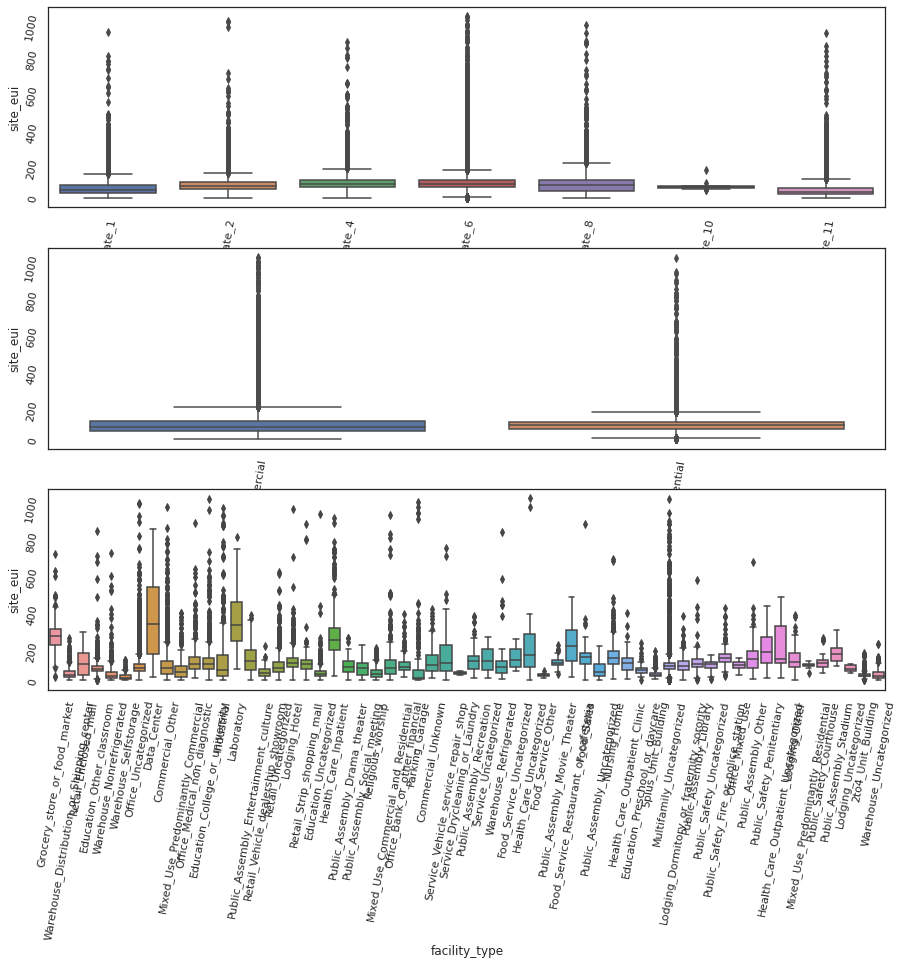

In [13]:
plt.figure(figsize=(15, 17))
sns.set(style="white")
i = 1
for col in categorical:
    plt.subplot(4, 1, i)
    ax = sns.boxplot(data=df, x=col, y="site_eui")
    i = i + 1
    ax.tick_params(labelrotation=80)
plt.show()

Observations
- We have data collected from 7 states, all of them presenting outliers and State 10 having less observations than the rest of them.  
- The energy consumption for commercial and residential buildings seem to have a similar distribution. We will look closer into this. 
- We can see from the boxplots above that we have a high cardinality for facilty type and high variation between them with outliers

In [14]:
df.columns

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

In [15]:
# look closer into the site_eui and energy star rating for commericial and residential buildings
pd.DataFrame(df.groupby(['building_class'])['site_eui', 'energy_star_rating'].mean())

site_eui  energy_star_rating
building_class                               
Commercial      85.755239           64.437008
Residential     80.240957           58.835967

- The energy consumption for commercial building and energy star rating are higher than the values for residential buildings. Let's look closer into each building class and facility type.

In [16]:
df_facility = pd.DataFrame(df.groupby(['facility_type', 'building_class'])['site_eui', 'energy_star_rating'].mean()).sort_values(by = ['site_eui'], ascending = False).reset_index()

In [17]:
df_facility

facility_type building_class    site_eui  \
0                                 Data_Center     Commercial  339.734876   
1                                  Laboratory     Commercial  329.448470   
2                       Health_Care_Inpatient     Commercial  248.340597   
3                Grocery_store_or_food_market     Commercial  241.135162   
4        Food_Service_Restaurant_or_cafeteria     Commercial  195.593925   
5        Health_Care_Outpatient_Uncategorized     Commercial  189.892345   
6                   Health_Care_Uncategorized     Commercial  183.945201   
7                  Public_Safety_Penitentiary     Commercial  170.904892   
8                     Public_Assembly_Stadium     Commercial  157.041663   
9         Service_Vehicle_service_repair_shop     Commercial  137.595749   
10                                 Food_Sales     Commercial  136.793222   
11                               Nursing_Home     Commercial  131.313887   
12       Public_Safety_Fire_or_police_station     Commercial  131.122766   
13                 Food_Service_Uncategorized     Commercial  128.801496   
14                      Public_Assembly_Other     Commercial  126.704295   
15                                 Industrial     Commercial  125.345295   
16                              Lodging_Other     Commercial  120.958325   
17      Public_Assembly_Entertainment_culture     Commercial  118.900412   
18              Office_Medical_non_diagnostic     Commercial  116.762294   
19                 Public_Assembly_Recreation     Commercial  115.177708   
20                      Service_Uncategorized     Commercial  113.565430   
21                         Commercial_Unknown     Commercial  113.151628   
22                 Retail_Strip_shopping_mall     Commercial  110.418481   
23            Education_College_or_university     Commercial  108.629116   
24                    Public_Assembly_Library     Commercial  105.849109   
25                              Lodging_Hotel     Commercial  104.934997   
26              Health_Care_Outpatient_Clinic     Commercial  103.613131   
27                   Public_Safety_Courthouse     Commercial  103.182163   
28              Public_Assembly_Movie_Theater     Commercial  103.095275   
29                       Retail_Enclosed_mall     Commercial  100.965937   
30                     Warehouse_Refrigerated     Commercial   96.525301   
31                           Commercial_Other     Commercial   92.642037   
32             Office_Bank_or_other_financial     Commercial   89.895736   
33       Mixed_Use_Commercial_and_Residential    Residential   89.529798   
34                  Multifamily_Uncategorized    Residential   83.878522   
35                Public_Safety_Uncategorized     Commercial   83.709161   
36                           Office_Mixed_use     Commercial   82.110316   
37        Mixed_Use_Predominantly_Residential    Residential   81.797872   
38   Lodging_Dormitory_or_fraternity_sorority     Commercial   81.595825   
39              Public_Assembly_Drama_theater     Commercial   80.916723   
40                       Retail_Uncategorized     Commercial   80.902854   
41             Public_Assembly_Social_meeting     Commercial   78.921954   
42                       Office_Uncategorized     Commercial   77.074389   
43                  Education_Other_classroom     Commercial   69.441531   
44         Mixed_Use_Predominantly_Commercial    Residential   69.133400   
45                             Parking_Garage     Commercial   67.351241   
46                      Lodging_Uncategorized     Commercial   66.595438   
47              Public_Assembly_Uncategorized     Commercial   62.872612   
48             Education_Preschool_or_daycare     Commercial   60.974215   
49         Retail_Vehicle_dealership_showroom     Commercial   46.640952   
50                    Education_Uncategorized     Commercial   46.172799   
51                          Religious_worship     Commercial   44.560675   
52  

- There are more commercial facilities than residential which is normal. It looks like there are a few commercial building types with higher energy consumption like Data_Center, Laboratory, Health_Care_Inpatient - facilities energy consumption 24/7. Let's create a new category for these types of facilities.

In [18]:
def building_class_group(d):
    if (d['building_class'] == 'Residential'):
        return 'Residential'
    elif (d['facility_type'] in ('Data_Center', 'Laboratory', 'Grocery_store_or_food_market', 'Health_Care_Inpatient', 'Health_Care_Uncategorized', 'Health_Care_Outpatient_Uncategorized', 'Food_Service_Restaurant_or_cafeteria')):
        return 'Commercial_24_7'
    else:
        return 'Commercial_others'

In [19]:
df['building_class_group'] = df.apply(building_class_group, axis=1)

In [20]:
df.head()

Year_Factor State_Factor building_class  \
0            1      State_1     Commercial   
1            1      State_1     Commercial   
2            1      State_1     Commercial   
3            1      State_1     Commercial   
4            1      State_1     Commercial   

                               facility_type  floor_area  year_built  \
0               Grocery_store_or_food_market     61242.0      1942.0   
1  Warehouse_Distribution_or_Shipping_center    274000.0      1955.0   
2                       Retail_Enclosed_mall    280025.0      1951.0   
3                  Education_Other_classroom     55325.0      1980.0   
4                  Warehouse_Nonrefrigerated     66000.0      1985.0   

   energy_star_rating  ELEVATION  january_min_temp  january_avg_temp  ...  \
0                11.0        2.4                36              50.5  ...   
1                45.0        1.8                36              50.5  ...   
2                97.0        1.8                36              50.5  ...   
3                46.0        1.8                36              50.5  ...   
4               100.0        2.4                36              50.5  ...   

   days_below_20F  days_below_10F  days_below_0F  days_above_80F  \
0               0               0              0              14   
1               0               0              0              14   
2               0               0              0              14   
3               0               0              0              14   
4               0               0              0              14   

   days_above_90F  days_above_100F  days_above_110F    site_eui  id  \
0               0                0                0  248.682615   0   
1               0                0                0   26.500150   1   
2               0                0                0   24.693619   2   
3               0                0                0   48.406926   3   
4               0                0                0    3.899395   4   

   building_class_group  
0       Commercial_24_7  
1     Commercial_others  
2     Commercial_others  
3     Commercial_others  
4     Commercial_others  

[5 rows x 61 columns]

# Impute mising values

In [21]:
# replace 0 values for year built and energy star rating with nan values so we can impute these too

df.loc[df["year_built"] == 0.0, "year_built"] = np.NAN
df.loc[df["energy_star_rating"] == 0.0, "energy_star_rating"] = np.NAN

In [22]:
# year_built, replace with current year.
df['year_built'] =df['year_built'].replace(np.nan, 2022)
#replacing energy of the values with mean
df['energy_star_rating']=df['energy_star_rating'].replace(np.nan,df['energy_star_rating'].mean())


In [23]:
df.isnull().sum()

Year_Factor                0
State_Factor               0
building_class             0
facility_type              0
floor_area                 0
                        ... 
days_above_100F            0
days_above_110F            0
site_eui                9705
id                         0
building_class_group       0
Length: 61, dtype: int64

# Encode categorical variables

In [24]:
# transform string values to numbers 
le = LabelEncoder()

# state factor column
df['State_Factor']= le.fit_transform(df['State_Factor']).astype("uint8")

# building class column

df['building_class']= le.fit_transform(df['building_class']).astype("uint8")

# facility type

df['facility_type']= le.fit_transform(df['facility_type']).astype("uint8")

# building class group 

df['building_class_group']= le.fit_transform(df['building_class_group']).astype("uint8")


# Handle numerical variables 

In [25]:
# drop categorical features which can be identified as numerical after the encoding
df_num = df.drop(['Year_Factor',
 'State_Factor',
 'building_class',
 'facility_type',
 'building_class_group',
 'id'], axis = 1)

In [26]:
numerical_features = list(df_num.select_dtypes(include=[np.number]).columns)
print(f'There are {len(numerical_features)} numerical columns in the dataset')

There are 55 numerical columns in the dataset


In [27]:
numerical_features

['floor_area',
 'year_built',
 'energy_star_rating',
 'ELEVATION',
 'january_min_temp',
 'january_avg_temp',
 'january_max_temp',
 'february_min_temp',
 'february_avg_temp',
 'february_max_temp',
 'march_min_temp',
 'march_avg_temp',
 'march_max_temp',
 'april_min_temp',
 'april_avg_temp',
 'april_max_temp',
 'may_min_temp',
 'may_avg_temp',
 'may_max_temp',
 'june_min_temp',
 'june_avg_temp',
 'june_max_temp',
 'july_min_temp',
 'july_avg_temp',
 'july_max_temp',
 'august_min_temp',
 'august_avg_temp',
 'august_max_temp',
 'september_min_temp',
 'september_avg_temp',
 'september_max_temp',
 'october_min_temp',
 'october_avg_temp',
 'october_max_temp',
 'november_min_temp',
 'november_avg_temp',
 'november_max_temp',
 'december_min_temp',
 'december_avg_temp',
 'december_max_temp',
 'cooling_degree_days',
 'heating_degree_days',
 'precipitation_inches',
 'snowfall_inches',
 'snowdepth_inches',
 'avg_temp',
 'days_below_30F',
 'days_below_20F',
 'days_below_10F',
 'days_below_0F',
 'day

# Numerical variables distribution

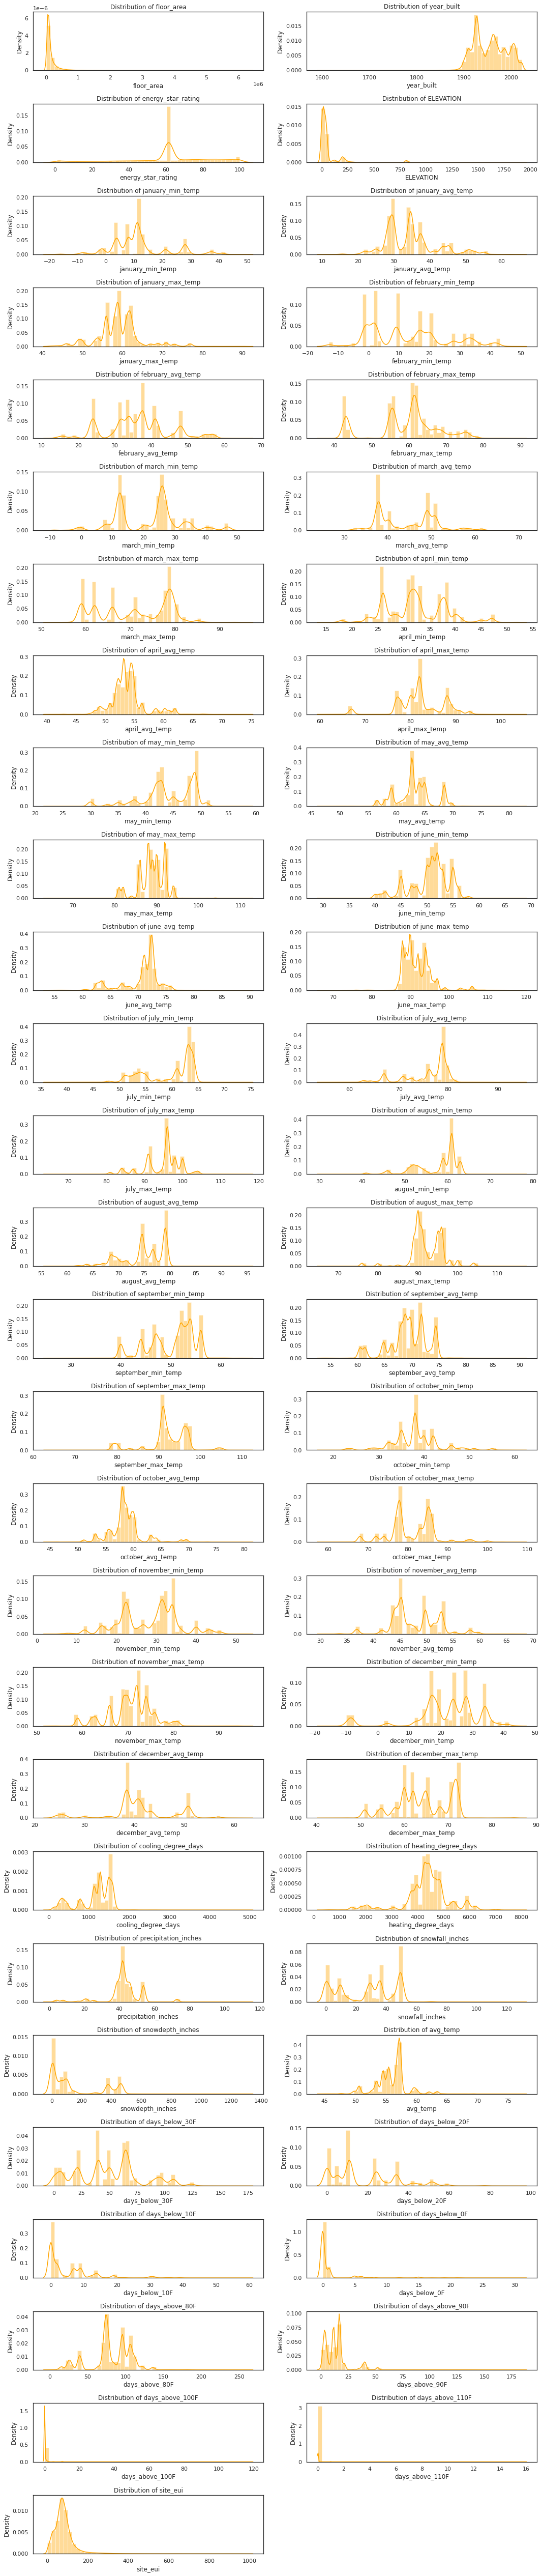

In [28]:
# Check distribution of numerical variables 
plt.figure(figsize=(15, 80))
for i, col in enumerate(df_num[numerical_features]):
    # Plot distribution 
    plt.subplot(32,2,i+1); sns.distplot(df[col], color='orange')
    plt.title(f'Distribution of {col}')
# Show the plot
plt.tight_layout()
plt.show()

- Many numerical features in the dataset are skewed to the right which might make our model not perform well as many algoritms require normally distributed features. We will apply log to these to normalise their distribition and reduce their spread. 


# Check multicoliniarty or relationships between numerical features

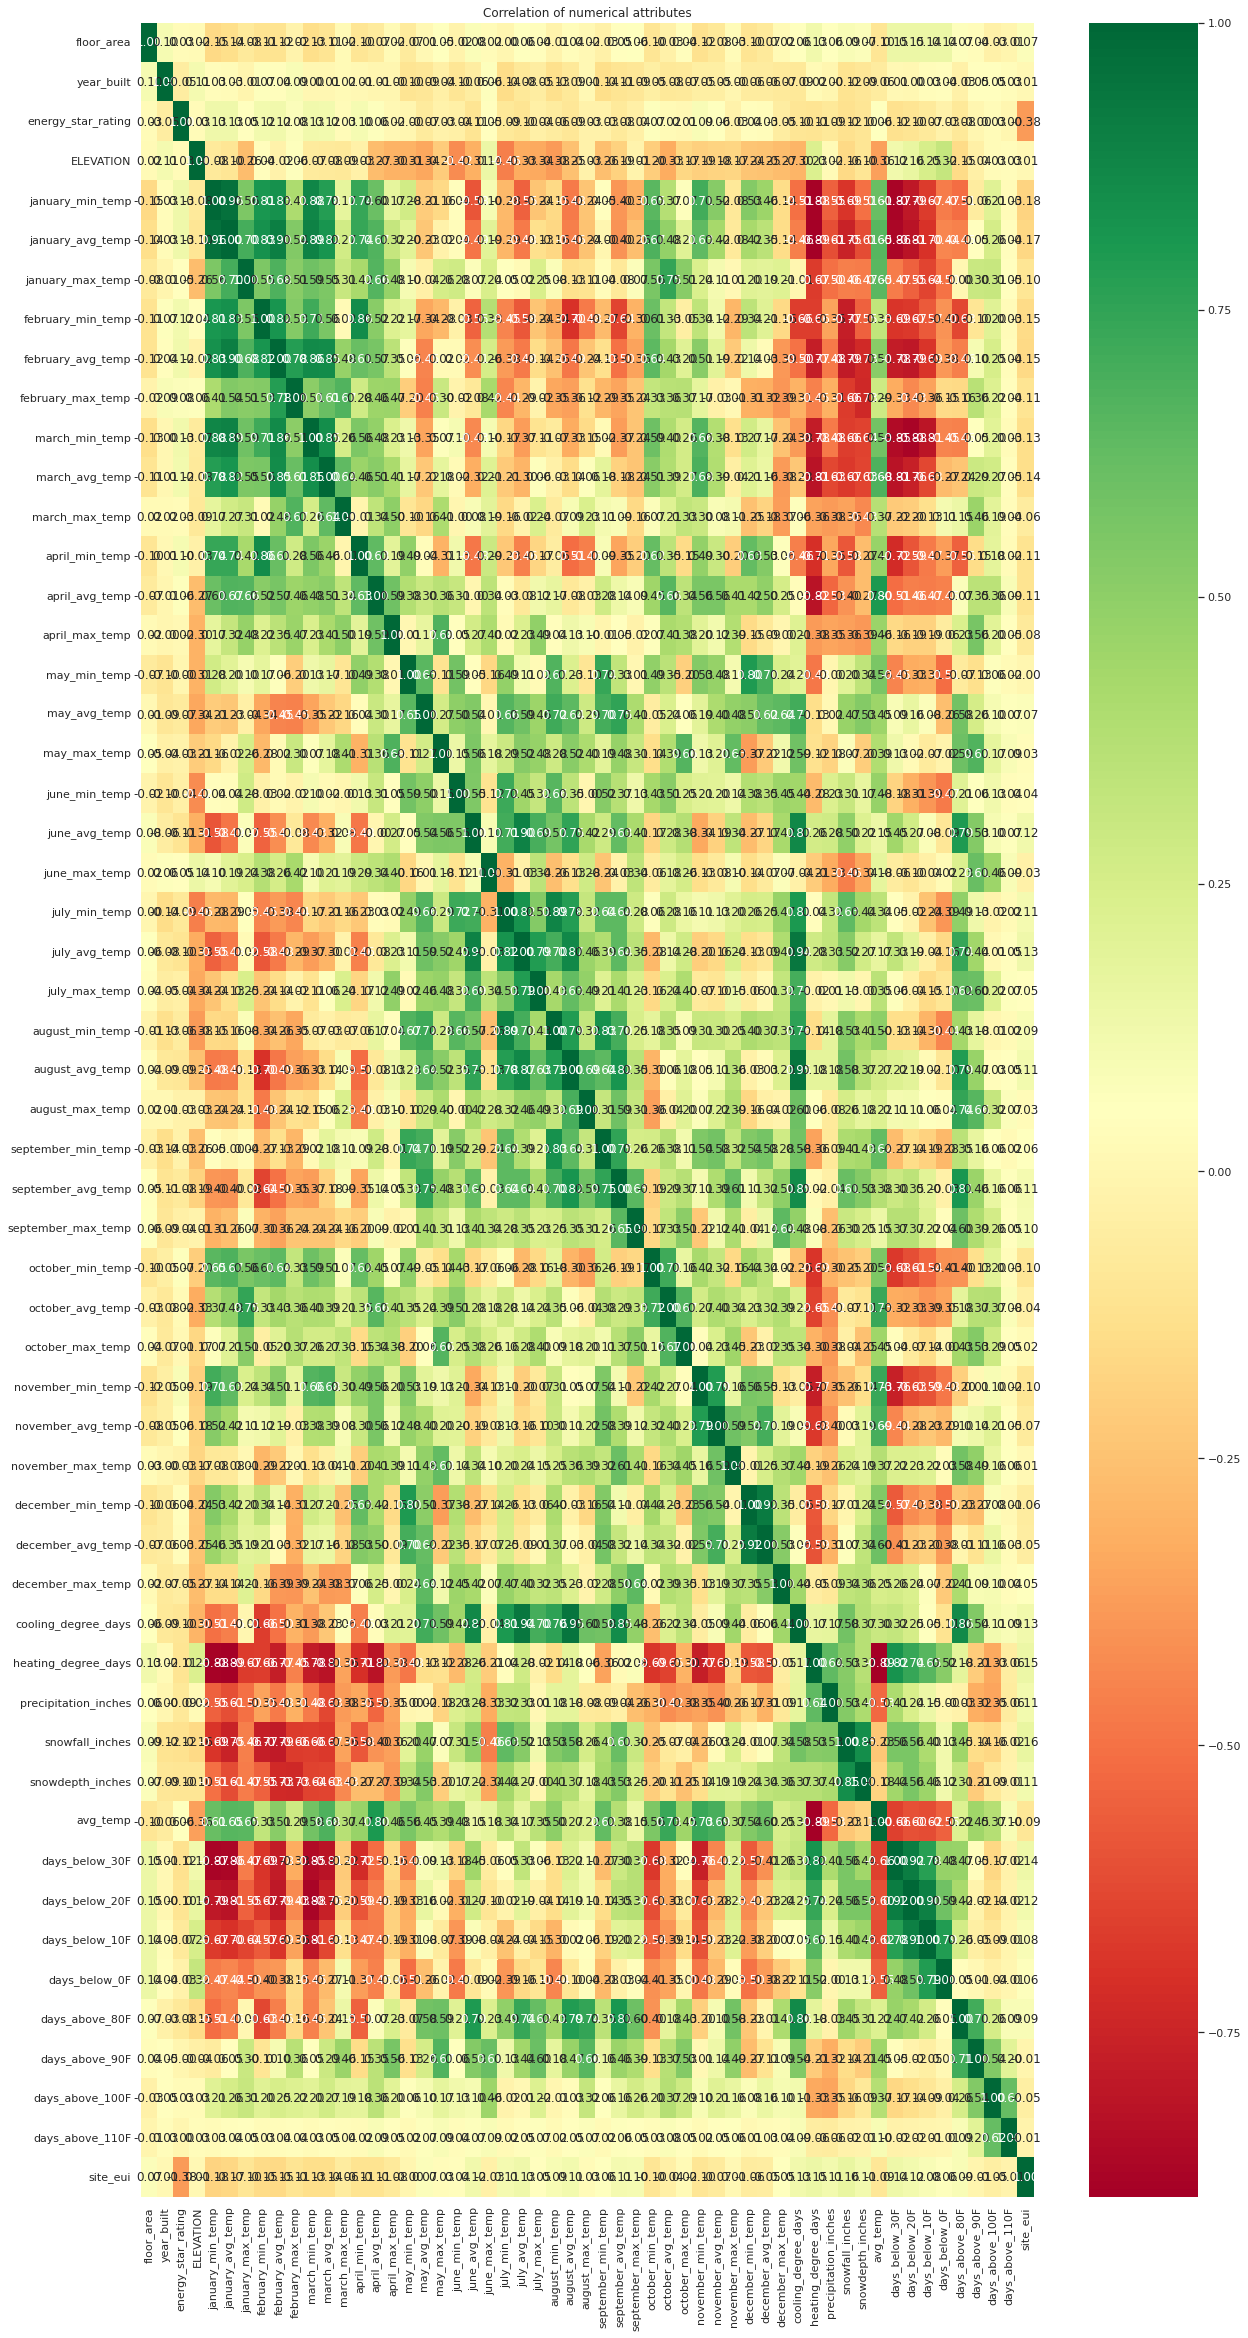

In [29]:
plt.figure(figsize=(20, 40))
plt.title('Correlation of numerical attributes')
sns.heatmap(df[numerical_features].corr(), annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

In [30]:
# drop highly correlated values 
cor_matrix = df[numerical_features].corr().abs()
# upper
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
# list columns with correlation more than 0.8 in order to drop them
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
# drop variables with correlation more than 0.8
numerical_clean = df[numerical_features].drop(to_drop, axis=1)

In [31]:
len(numerical_clean.columns)

35

In [32]:
numerical_clean.columns

Index(['floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_max_temp', 'february_max_temp',
       'march_max_temp', 'april_avg_temp', 'april_max_temp', 'may_min_temp',
       'may_avg_temp', 'may_max_temp', 'june_min_temp', 'june_avg_temp',
       'june_max_temp', 'july_min_temp', 'july_max_temp', 'august_max_temp',
       'september_max_temp', 'october_min_temp', 'october_avg_temp',
       'october_max_temp', 'november_min_temp', 'november_avg_temp',
       'november_max_temp', 'december_min_temp', 'december_max_temp',
       'precipitation_inches', 'snowfall_inches', 'days_below_0F',
       'days_above_90F', 'days_above_100F', 'days_above_110F', 'site_eui'],
      dtype='object')

# Check distribution between numerical features and target variable site_eui

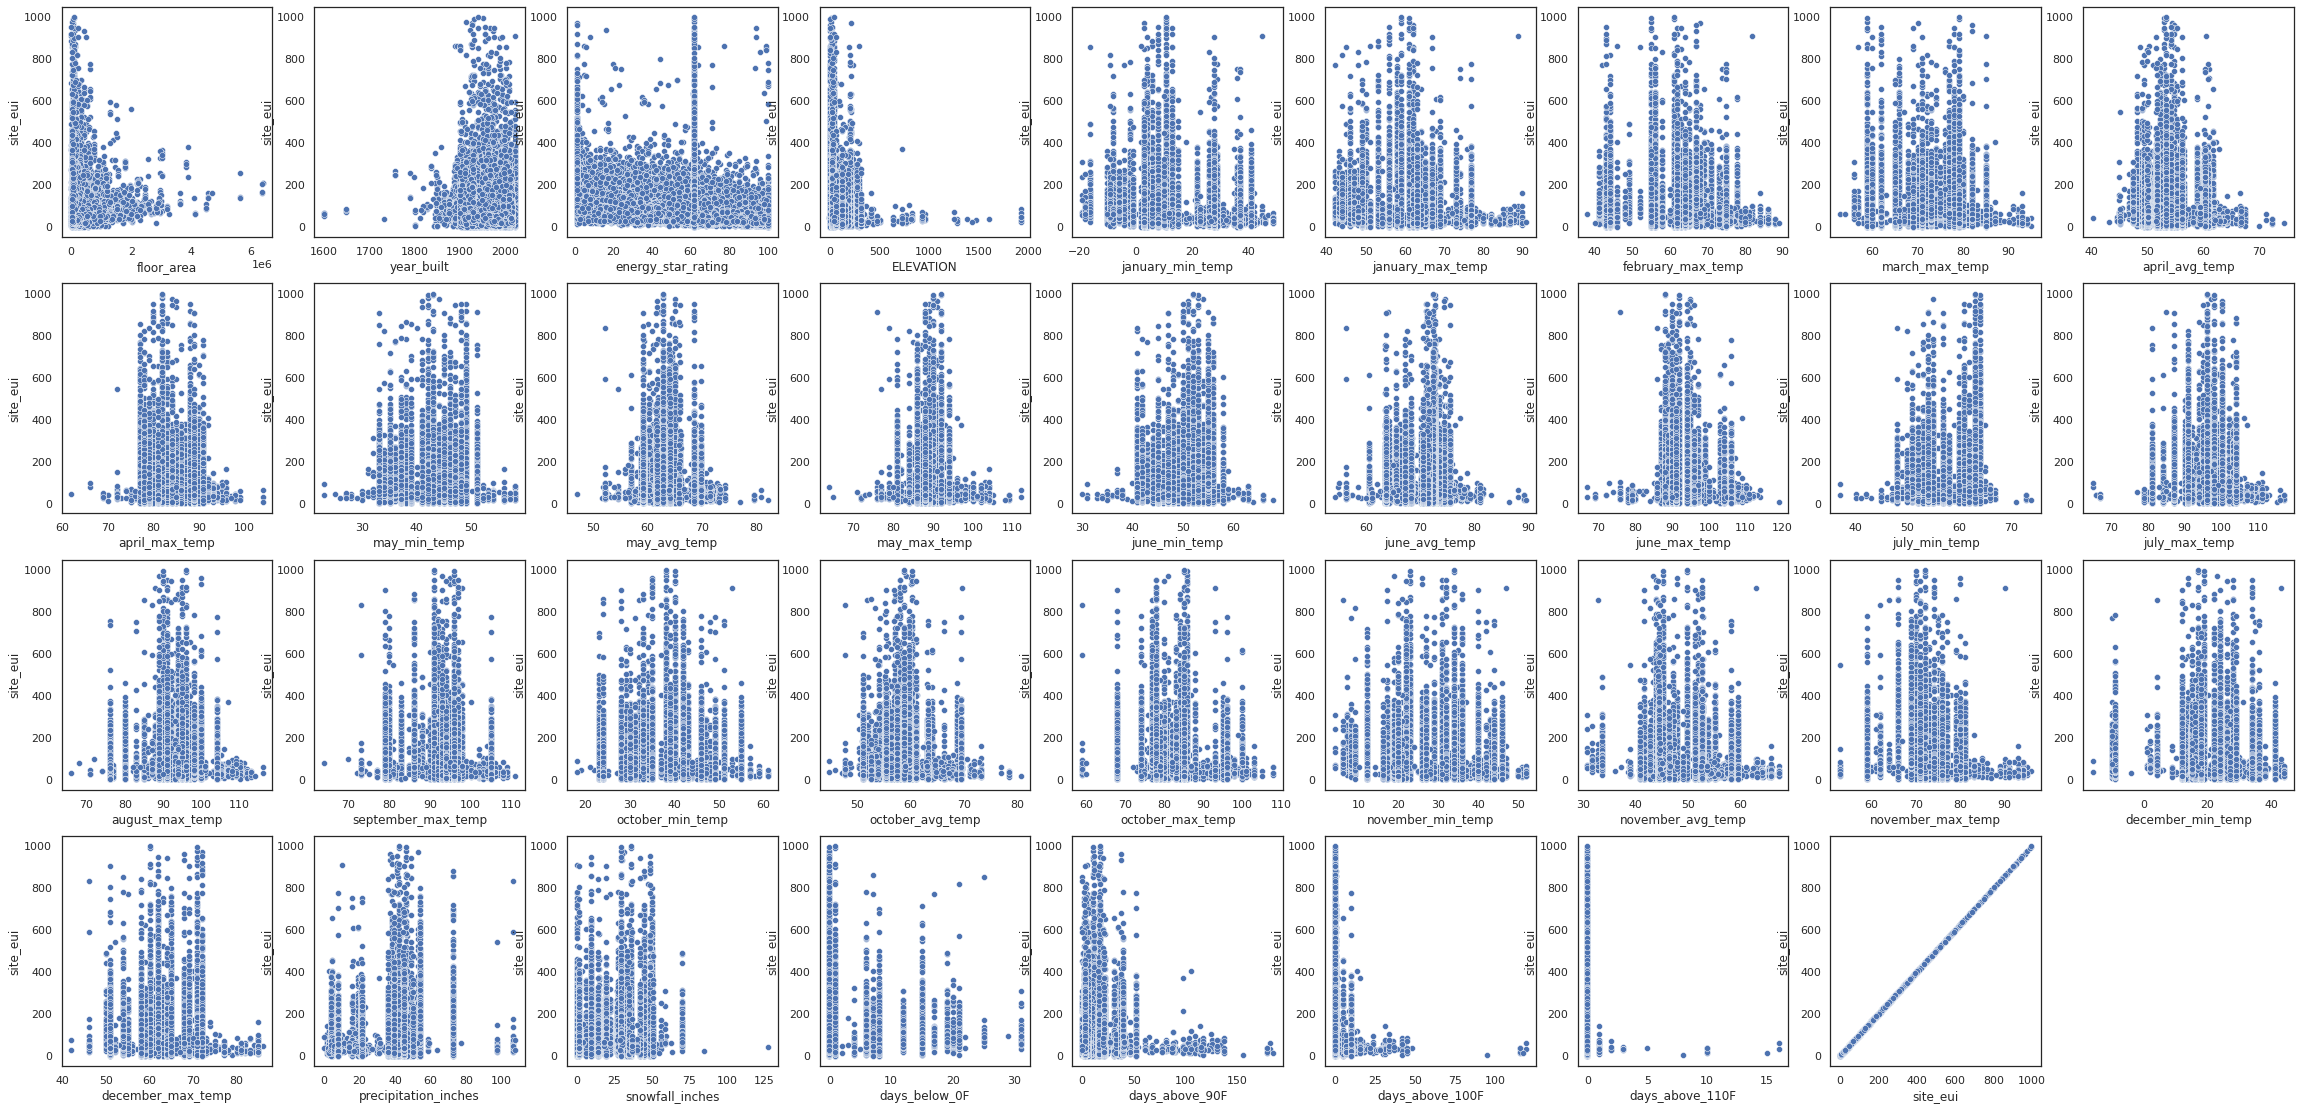

In [33]:
features_1 = numerical_clean.columns.tolist()

plt.figure(figsize = (40,50))
for i in enumerate(features_1):
    plt.subplot(10,9,i[0]+1)
    sns.scatterplot(x=i[1], y='site_eui',  data=df)
    # sns.scatterplot(x="site_eui", y=i[1],  data=df_1)

- Observed temperatures of the remaining features range between - 20F min in January and 120 Fahrenheit degrees max during June. 
- Most of the buildings were built after 1900 with a few outliers older than this 
- Floor area, Elevaion and days above 90, 100 or 110F degrees have significant outliers. 

# Log transformation of skewed data¶

In [34]:
#  Log transform function
def log_transform(data, to_log):
    X = data.copy()
    for item in to_log:
        # Add 20 to the data to prevent infinity values
        X[item] = np.log(20+X[item])
    return X

In [35]:
numerical_clean.drop('site_eui', axis = 1, inplace = True)

In [36]:
# Before log
numerical_clean.describe()

floor_area    year_built  energy_star_rating     ELEVATION  \
count  8.546200e+04  85462.000000        85462.000000  85462.000000   
mean   1.656694e+05   1955.272963           61.532939     58.325913   
std    2.486965e+05     34.313062           23.249377    118.276994   
min    9.430000e+02   1600.000000            1.000000     -6.400000   
25%    6.115500e+04   1927.000000           56.000000     11.900000   
50%    9.041100e+04   1955.000000           61.532939     25.600000   
75%    1.671960e+05   1983.000000           77.000000     42.700000   
max    6.385382e+06   2022.000000          100.000000   1924.500000   

       january_min_temp  january_max_temp  february_max_temp  march_max_temp  \
count      85462.000000      85462.000000       85462.000000    85462.000000   
mean          11.669502         59.163230          59.446386       70.927675   
std            9.801683          5.425332           8.637622        7.891359   
min          -19.000000         42.000000          38.000000       53.000000   
25%            6.000000         56.000000          56.000000       62.000000   
50%           11.000000         59.000000          61.000000       71.000000   
75%           13.000000         62.000000          64.000000       79.000000   
max           49.000000         91.000000          89.000000       95.000000   

       april_avg_temp  april_max_temp  ...  november_avg_temp  \
count    85462.000000    85462.000000  ...       85462.000000   
mean        53.832990       82.177471  ...          47.742669   
std          2.743682        5.146350  ...           4.522633   
min         40.280000       61.000000  ...          30.766667   
25%         52.333333       80.000000  ...          44.733333   
50%         53.333333       82.000000  ...          46.616667   
75%         54.766667       86.000000  ...          51.283333   
max         74.500000      104.000000  ...          67.416667   

       november_max_temp  december_min_temp  december_max_temp  \
count       85462.000000       85462.000000       85462.000000   
mean           70.747420          21.759098          64.014778   
std             4.791307          10.497901           6.053359   
min            53.000000         -16.000000          42.000000   
25%            69.000000          17.000000          60.000000   
50%            71.000000          24.000000          64.000000   
75%            74.000000          28.000000          71.000000   
max            96.000000          44.000000          86.000000   

       precipitation_inches  snowfall_inches  days_below_0F  days_above_90F  \
count          85462.000000     85462.000000   85462.000000    85462.000000   
mean              42.334834        26.796569       0.927441       13.818247   
std               10.253751        18.265343       2.828053       11.226827   
min                0.000000         0.000000       0.000000        0.000000   
25%               40.970000         9.600000       0.000000        5.000000   
50%               42.170000        29.600000       0.000000       12.000000   
75%               46.320000        44.700000       0.000000       17.000000   
max              112.920000       127.300000      31.000000      185.000000   

       days_above_100F  days_above_110F  
count     85462.000000     85462.000000  
mean          0.271828         0.002165  
std           2.130802         0.133828  
min           0.000000         0.000000  
25%           0.000000         0.000000  
50%           0.000000         0.000000  
75%           0.000000         0.000000  
max         119.000000        16.000000  

[8 rows x 34 columns]

In [37]:
to_log = numerical_clean.columns 
# after log
numerical_clean_l = log_transform(numerical_clean, to_log)
numerical_clean_l.describe()

floor_area    year_built  energy_star_rating     ELEVATION  \
count  85462.000000  85462.000000        85462.000000  85462.000000   
mean      11.551073      7.588311            4.344740      3.957922   
std        0.885565      0.017378            0.370202      0.747395   
min        6.870053      7.390181            3.044522      2.610070   
25%       11.021494      7.574045            4.330733      3.462606   
50%       11.412342      7.588324            4.401007      3.819908   
75%       12.027042      7.602401            4.574711      4.138361   
max       15.669525      7.621685            4.787492      7.572760   

       january_min_temp  january_max_temp  february_max_temp  march_max_temp  \
count      85462.000000      85462.000000       85462.000000    85462.000000   
mean           3.407388          4.369191           4.368903        4.506232   
std            0.319592          0.068035           0.112560        0.087930   
min            0.000000          4.127134           4.060443        4.290459   
25%            3.258097          4.330733           4.330733        4.406719   
50%            3.433987          4.369448           4.394449        4.510860   
75%            3.496508          4.406719           4.430817        4.595120   
max            4.234107          4.709530           4.691348        4.744932   

       april_avg_temp  april_max_temp  ...  november_avg_temp  \
count    85462.000000    85462.000000  ...       85462.000000   
mean         4.301130        4.625416  ...           4.213493   
std          0.036557        0.051208  ...           0.066692   
min          4.099000        4.394449  ...           3.927240   
25%          4.281285        4.605170  ...           4.170276   
50%          4.295015        4.624973  ...           4.198955   
75%          4.314372        4.663439  ...           4.266663   
max          4.548600        4.820282  ...           4.470686   

       november_max_temp  december_min_temp  december_max_temp  \
count       85462.000000       85462.000000       85462.000000   
mean            4.506666           3.682192           4.428356   
std             0.053413           0.360739           0.072932   
min             4.290459           1.386294           4.127134   
25%             4.488636           3.610918           4.382027   
50%             4.510860           3.784190           4.430817   
75%             4.543295           3.871201           4.510860   
max             4.753590           4.158883           4.663439   

       precipitation_inches  snowfall_inches  days_below_0F  days_above_90F  \
count          85462.000000     85462.000000   85462.000000    85462.000000   
mean               4.115560         3.754197       3.034323        3.478505   
std                0.198090         0.449018       0.107935        0.278870   
min                2.995732         2.995732       2.995732        2.995732   
25%                4.110382         3.387774       2.995732        3.218876   
50%                4.129873         3.903991       2.995732        3.465736   
75%                4.194492         4.169761       2.995732        3.610918   
max                4.889747         4.992471       3.931826        5.323010   

       days_above_100F  days_above_110F  
count     85462.000000     85462.000000  
mean          3.006426         2.995824  
std           0.065574         0.005290  
min           2.995732         2.995732  
25%           2.995732         2.995732  
50%           2.995732         2.995732  
75%           2.995732         2.995732  
max           4.934474         3.583519  

[8 rows x 34 columns]

# Feature scaling

In [38]:
from sklearn.preprocessing import StandardScaler

# apply this on numerical features only 
scale_train = StandardScaler().fit(numerical_clean_l)

numerical_clean_l[numerical_clean.columns] = scale_train.transform(numerical_clean_l)

In [39]:
# concatenate transformed numerical data into the final dataset 
final_df = pd.concat([df.drop(df_num, axis=1), numerical_clean_l], axis=1)
final_df.shape

# add back target 
final_df['site_eui'] = df['site_eui']

# remove id 
final_df.drop('id', axis = 1, inplace = True)

In [40]:
final_df

Year_Factor  State_Factor  building_class  facility_type  \
0               1             0               0             13   
1               1             0               0             55   
2               1             0               0             48   
3               1             0               0              6   
4               1             0               0             56   
...           ...           ...             ...            ...   
9700            7             2               1              1   
9701            7             2               1              1   
9702            7             2               1              1   
9703            7             2               1              1   
9704            7             2               1              1   

      building_class_group  floor_area  year_built  energy_star_rating  \
0                        0   -0.596411   -0.379300           -2.460167   
1                        1    1.095220    0.000733           -0.460165   
2                        1    1.119780   -0.115933            1.127592   
3                        1   -0.711111    0.724587           -0.418923   
4                        1   -0.511947    0.868271            1.195981   
...                    ...         ...         ...                 ...   
9700                     2    1.219666    1.666340            1.173377   
9701                     2   -1.230859   -1.325600            1.057425   
9702                     2   -1.011634    1.694639            1.057425   
9703                     2   -1.591129    1.068828            0.676338   
9704                     2   -0.928333    1.126002            0.886249   

      ELEVATION  january_min_temp  ...  november_max_temp  december_min_temp  \
0     -1.135765          1.933614  ...           0.283138           0.951275   
1     -1.172093          1.933614  ...           0.283138           0.951275   
2     -1.172093          1.933614  ...           0.283138           0.951275   
3     -1.172093          1.933614  ...           0.283138           0.951275   
4     -1.135765          1.933614  ...           0.283138           0.951275   
...         ...               ...  ...                ...                ...   
9700   3.700754          0.958053  ...          -1.644285           0.523952   
9701  -0.158511          0.958053  ...          -1.644285           0.523952   
9702   3.700754          0.958053  ...          -1.644285           0.523952   
9703   3.700754          0.958053  ...          -1.644285           0.523952   
9704  -0.158511          0.958053  ...          -1.644285           0.523952   

      december_max_temp  precipitation_inches  snowfall_inches  days_below_0F  \
0              1.131239             -2.603802        -1.689171      -0.357536   
1              1.131239             -2.603802        -1.689171      -0.357536   
2              1.131239             -2.603802        -1.689171      -0.357536   
3              1.131239             -2.603802        -1.689171      -0.357536   
4              1.131239             -2.603802        -1.689171      -0.357536   
...                 ...                   ...              ...            ...   
9700          -1.520158              0.283756        -1.283124      -0.357536   
9701          -1.520158              0.283756        -1.283124      -0.357536   
9702          -1.520158              0.283756        -1.283124      -0.357536   
9703          -1.520158              0.283756        -1.283124      -0.357536   
9704          -1.520158              0.283756        -1.283124      -0.357536   

      days_above_90F  days_above_100F  days_above_110F    site_eui  
0          -1.731184        -0.163074        -0.017375  248.682615  
1          -1.731184        -0.163074        -0.017375   26.500150  
2          -1.731184        -0.163074        -0.017375   24.693619  
3          -1.731184        -0.163074        -0.017375   48.406926  
4          -1.731184        -0.163074        

In [41]:
# separate data to validate the results 
valid = final_df[final_df['site_eui'].isnull()].reset_index(drop = True)

train = final_df[final_df['site_eui'].notnull()]

In [42]:
train.shape, valid.shape, final_df.shape

((75757, 40), (9705, 40), (85462, 40))

In [43]:
X = train.drop('site_eui', axis = 1)
y = train['site_eui']

# Train model

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=50)

In [45]:
# baseline Regression model

from sklearn.linear_model import LinearRegression

baseline_model = LinearRegression()

baseline_model.fit(X_train, y_train)

y_train_baseline_predict = baseline_model.predict(X_train)
y_test_baseline_predict = baseline_model.predict(X_test)

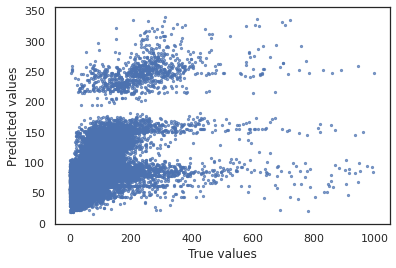

In [46]:
plt.scatter(y_train, y_train_baseline_predict, s=5, alpha=0.7)
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

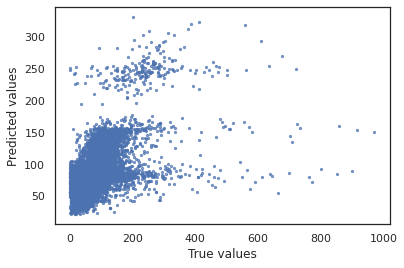

In [47]:
plt.scatter(y_test, y_test_baseline_predict, s=5, alpha=0.7)
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

In [48]:
# Feature importance

from matplotlib import pyplot

# get importance
importance = baseline_model.coef_

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -4.85808
Feature: 1, Score: -0.22766
Feature: 2, Score: 147.77270
Feature: 3, Score: -0.31678
Feature: 4, Score: -159.27871
Feature: 5, Score: 0.20374
Feature: 6, Score: 0.11876
Feature: 7, Score: -21.08028
Feature: 8, Score: -0.82419
Feature: 9, Score: 3.31760
Feature: 10, Score: -7.42708
Feature: 11, Score: -9.64284
Feature: 12, Score: 4.37184
Feature: 13, Score: -3.84923
Feature: 14, Score: 5.75649
Feature: 15, Score: -0.04594
Feature: 16, Score: -2.80825
Feature: 17, Score: 2.06042
Feature: 18, Score: 4.33823
Feature: 19, Score: 0.60573
Feature: 20, Score: -0.16666
Feature: 21, Score: 0.21787
Feature: 22, Score: -3.34235
Feature: 23, Score: 0.37088
Feature: 24, Score: 5.72645
Feature: 25, Score: 2.48270
Feature: 26, Score: 1.05031
Feature: 27, Score: 3.21280
Feature: 28, Score: 1.74769
Feature: 29, Score: -2.91624
Feature: 30, Score: -3.21039
Feature: 31, Score: -0.65839
Feature: 32, Score: -1.39317
Feature: 33, Score: -0.30425
Feature: 34, Score: 5.29340
Feature

In [49]:
# metrics 

from sklearn.metrics import mean_squared_error, r2_score

train_mse = mean_squared_error(y_train, y_train_baseline_predict)
test_mse = mean_squared_error(y_test, y_test_baseline_predict)
print(
    f"MSE on the training data is {np.round(train_mse, 2)}.",
    f"MSE on the test data is {np.round(test_mse, 2)}.",
)

train_r2 = r2_score(y_train, y_train_baseline_predict)
test_r2 = r2_score(y_test, y_test_baseline_predict)
print(
    f"r2 on the training data is {np.round(train_r2, 2)}.",
    f"r2 on the test data is {np.round(test_r2, 2)}.",
)

MSE on the training data is 2417.38. MSE on the test data is 2200.44.
r2 on the training data is 0.3. r2 on the test data is 0.31.


In [50]:
# apply lightgbm model

model = lightgbm.LGBMRegressor()
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

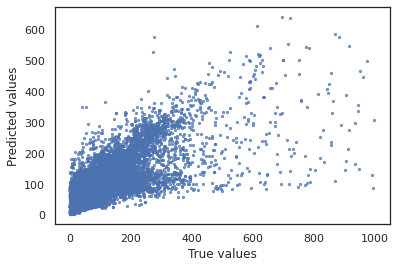

In [51]:
plt.scatter(y_train, y_train_predict, s=5, alpha=0.7)
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

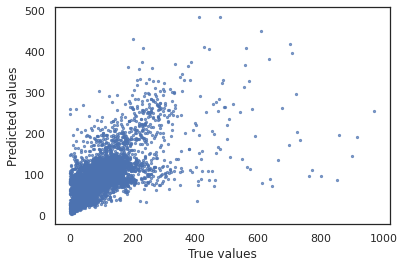

In [52]:
plt.scatter(y_test, y_test_predict, s=5, alpha=0.7)
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

In [53]:
train_mse = mean_squared_error(y_train, y_train_predict)
test_mse = mean_squared_error(y_test, y_test_predict)
print(
    f"MSE on the training data is {np.round(train_mse, 2)}.",
    f"MSE on the test data is {np.round(test_mse, 2)}.",
)

train_r2 = r2_score(y_train, y_train_predict)
test_r2 = r2_score(y_test, y_test_predict)
print(
    f"r2 on the training data is {np.round(train_r2, 2)}.",
    f"r2 on the test data is {np.round(test_r2, 2)}.",
)

MSE on the training data is 1552.65. MSE on the test data is 1708.09.
r2 on the training data is 0.55. r2 on the test data is 0.46.


# Fine tune model 

In [54]:
#  Define list to store result 
final_result = list()

# Define list to store result 
final_model = list()

# Initialise kfold
n=6

# Search for best param
def best_param_search(model, pipe, new_params, kf, groups=None):
    
    # Define cv - with no grouping
    if groups is None:
        print('GROUP is none')
        cv =  KFold(n_splits=n, random_state=42, shuffle=True)
    # Define cv - with grouping
    else:
        print('GROUP is NOT none')
        cv = list(GroupKFold(n_splits=n).split(X,y,groups))
    
    # Start GridSearchCV
    clf = GridSearchCV(pipe, param_grid=new_params, cv=cv, verbose=False)
        
    # Fit to model with best hyper-param
    clf.fit(X, y)
    # Best score 
    print(f'Best score: {clf.best_score_}')
    # Best param
    print(f'Best param: {clf.best_params_}')
    # Print test result
    y_test_predict = clf.best_estimator_.predict(X_test)
    # Cakcukate RMSE
    score = round(mean_squared_error(y_test, y_test_predict, squared=False),3)
    
    #return clf.best_params_, score 
    return clf, {'Model':model, 'Best hyperparam': clf.best_params_, 'RMSE':round(score,5)}

In [55]:
def model_run(model, clf, X, y):

    # Evaluate error rates and append to lists
    y_test_predict = clf.predict(X)
    score = round(mean_squared_error(y_test, y_test_predict, squared=False),3)

    return {'Model':model, \
            'RMSE': round(score,5)}

In [60]:
# Define lg params
params = {'objective': ["root_mean_squared_error"],
          'metric': ['rmse'],
          'boosting_type':['gbdt'],
          "max_depth":[int(x) for x in np.linspace(-1,200, num=3)],
          "num_leaves":[int(x) for x in np.linspace(2,50, num=3)],
          'learning_rate': [0.1,0.2,0.3]}

model = lightgbm.LGBMRegressor()

# Search for best param
lg_clf2, lg2 = best_param_search('LGBM (Groupkfold)', model, params, kf=None, groups=X['Year_Factor'])
# Print result
final_model.append(model_run('LGBM (Groupkfold)', lg_clf2, X=X_test, y=y_test))

# Append result
final_result.append(lg2)
final_result
final_model

GROUP is NOT none
Best score: 0.3987290075026113
Best param: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'rmse', 'num_leaves': 50, 'objective': 'root_mean_squared_error'}


[{'Model': 'LGBM (Groupkfold)', 'RMSE': 36.98}]

In [61]:
#!pip install shap

In [63]:
# import RandomForest model 
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=10, random_state=0)

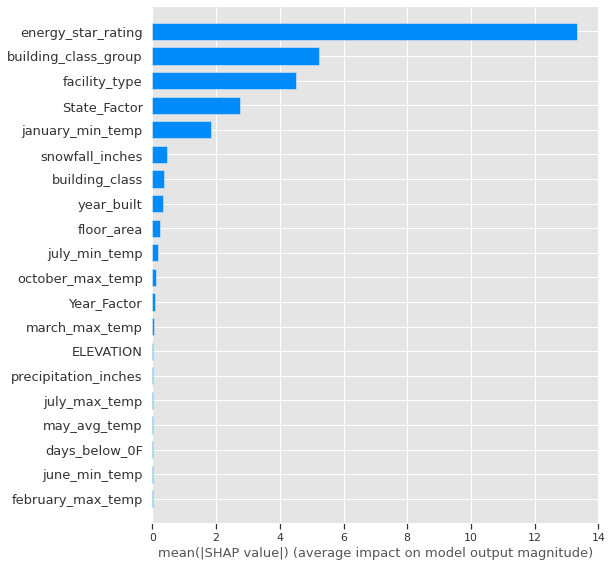

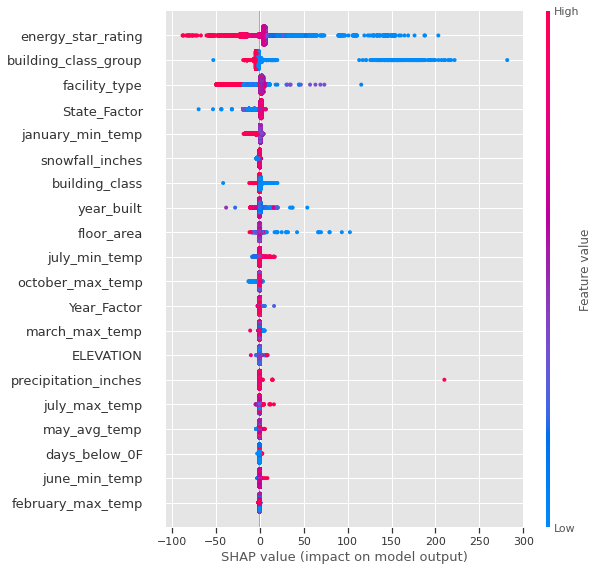

In [65]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar",
                  title = "")

shap.summary_plot(shap_values, X_test)

In [67]:
#lg_clf.predict()
valid.drop('site_eui', inplace = True, axis =1)
# testdata prediction
prediction = lg_clf2.best_estimator_.predict(valid)
prediction

array([276.80864066, 218.39598683, 343.44596298, ...,  39.27891057,
        41.15171947,  39.58312319])

In [68]:
print(prediction.shape)
sub = pd.read_csv("/content/drive/MyDrive/WiDS Datathon 2022/sample_solution.csv")
sub.shape
sub["site_eui"] = prediction
# EDIT THIS TITLE
# sub.to_csv("/content/drive/MyDrive/submissionGitHub.csv", index = False)

(9705,)
